# <span style="color:red">4. Solution</span>

## Portfolio Management
### MLP Training

#### January 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Carry in Equities

### Data
You will need the files in the github repo, 
* `data/spx_carry_weekly.xlsx`
* `data/spx_returns_weekly.xlsx`

### 1. Data Processing
* Take the intersection of dates of the two data sets, so you have one unified set of dates.
* Report the maximum and minimum dividend yields from the entire panel of data. To which stocks did they belong?

### 2. Static Carry
* Starting at the beginning of the sample, build a portfolio where you go (equally) long the top 100 stocks as ranked by dividend yield, and you short (equally) the smallest 100 stocks as ranked by dividend yield.
* Using those weights, calculate the return of your portfolio over time. 

Report the following annualized stats
* mean
* volatility
* Sharpe

### 3. Challenges

Mention two challenges of this strategy.

### 4. Dynamic Carry

Make the carry strategy of `2` dynamic by recalculating the weights every period.

Report the performance statistics.

### 5. Market Exposure

Calculate a linear factor decomposition of your carry strategy (from part `2` or part `4`) against `SPY`.

Report the...
* alpha (annualized)
* beta
* r-squared

***

### <span style="color:red">Data</span>

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [3]:
import sys
sys.path.insert(0, '../cmds')
from portfolio import performanceMetrics, tailMetrics, get_ols_metrics
#from risk import *
from porttools import heatmap_vector

In [4]:
FILE_CARRY = '../data/spx_carry_weekly.xlsx'
FILE_RETS = '../data/spx_returns_weekly.xlsx'

SHEET_CARRY = 's&p500 dvd yield'
SHEET_RETS = 's&p500 rets'
SHEET_INFO = 's&p500 names'
SHEET_SPY = 'benchmark rets'

FREQ = 52

info = pd.read_excel(FILE_CARRY,sheet_name=SHEET_INFO)
info.set_index('ticker',inplace=True)

dvd_raw = pd.read_excel(FILE_CARRY,sheet_name=SHEET_CARRY).set_index('date')
rets_raw = pd.read_excel(FILE_RETS,sheet_name=SHEET_RETS).set_index('date')
bench_raw = pd.read_excel(FILE_RETS,sheet_name=SHEET_SPY).set_index('date')

***

### **<span style="color:red">Solution 1.1</span>**

In [5]:
dvd, rets = dvd_raw.align(rets_raw,axis=0,join='inner')
dvd, rets = dvd.align(rets,axis=1,join='inner')

T,N = dvd.shape

In [6]:
dvd_stats = pd.DataFrame(index=['min','max'], columns=['ticker'])

idx_min = dvd.min().idxmin()
idx_max = dvd.max().idxmax()

idx_min_dt = dvd.min(axis=1).idxmin()
idx_max_dt = dvd.max(axis=1).idxmax()

dvd_stats['ticker'] = [idx_min,idx_max]
dvd_stats['name'] = [info.loc[idx_min,'security name'], info.loc[idx_max,'security name']]

dvd_stats['date'] = [idx_min_dt,idx_max_dt]

dvd_stats['value'] = [dvd.min().min(), dvd.max().max()]
dvd_stats.style.format({'value':'{:.2%}','date':'{:%Y-%m-%d}'})

,ticker,name,date,value
min,COO,Cooper Cos Inc/The,2021-09-03,0.01%
max,TRGP,Targa Resources Corp,2020-04-03,57.50%


### **<span style="color:red">Solution 1.2 and 1.4</span>**

Building the weights at every time period for use in `1.4`.

Some care is taken to figure out the lowest 100 ranked given that the number of stocks with a valid dividend-yield (not NaN) changes over time. Thus, to find the bottom 100 ranked, must check row-by-row using the (changing) total number of ranked stocks.

In [7]:
CUTOFF = 100

rank_dvd = dvd.rank(axis=1,method='first',ascending=False)
num_ranked = rank_dvd.max(axis=1)

wts = pd.DataFrame(index=dvd.index,columns=dvd.columns,dtype=float)
for dt in wts.index:
    idx = rank_dvd.loc[dt,:]<=CUTOFF
    wts.loc[dt,idx] = .01
    idx = rank_dvd.loc[dt,:] > (num_ranked.loc[dt]-CUTOFF)
    wts.loc[dt,idx] = -.01

Use just the first row of weights, and evaluate the portfolio.

Could assume you knew these weights at the start of the sample, or that you set them after the first date and operated them to achieve the returns starting on the second date.

We'll do the latter.

In [8]:
port_rets = pd.DataFrame(index=rets.index,columns=['static'],data=(rets.iloc[1:] * wts.iloc[0,:]).sum(axis=1))

Building the dynamic returns with a lag to reflect that we set the portfolio at the end of $t$ and realize the return the following period:

$w_t\, r_{t+1}$

In [9]:
port_rets['dynamic'] = (wts.shift() * rets).sum(axis=1)

#### Performance

<Axes: xlabel='date'>

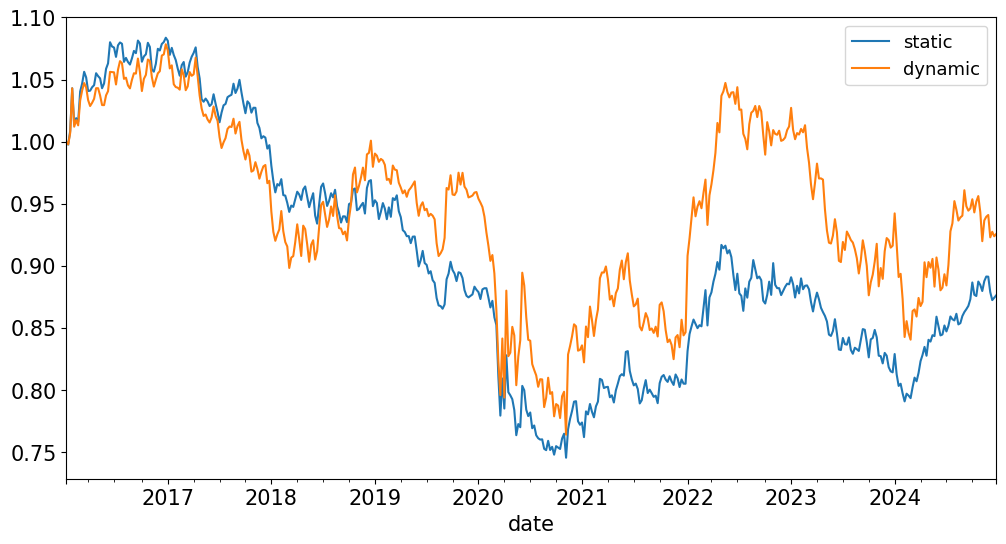

In [10]:
(1+port_rets).cumprod().plot()

### **<span style="color:red">Solution 1.3</span>**

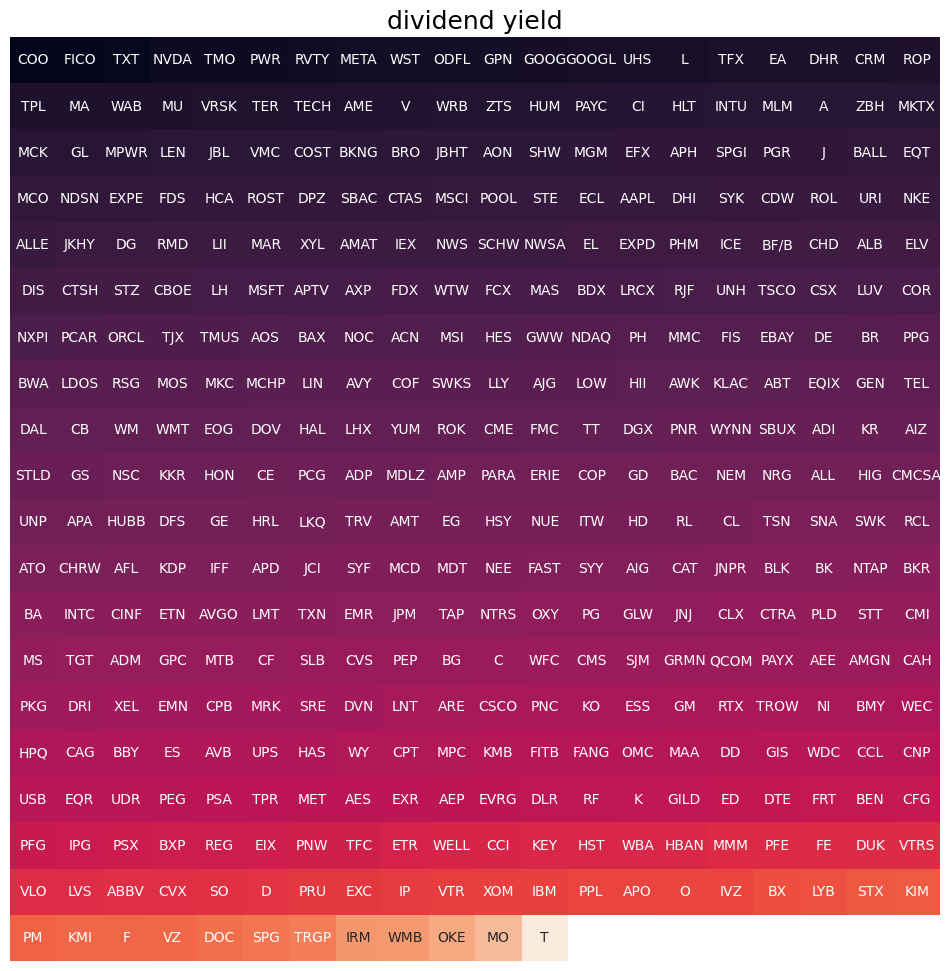

In [11]:
temp = dvd.mean().sort_values()
heatmap_vector(temp,labs=temp.index,Ngrid=20,plottitle='dividend yield')

In [12]:
info.loc[temp.head(15).index,['security name']]

,security name
COO,Cooper Cos Inc/The
FICO,Fair Isaac Corp
TXT,Textron Inc
NVDA,NVIDIA Corp
TMO,Thermo Fisher Scientific Inc
PWR,Quanta Services Inc
RVTY,Revvity Inc
META,Meta Platforms Inc
WST,West Pharmaceutical Services I
ODFL,Old Dominion Freight Line Inc


In [13]:
info.loc[temp.tail(15).index,['security name']]

,security name
LYB,LyondellBasell Industries NV
STX,Seagate Technology Holdings PL
KIM,Kimco Realty Corp
PM,Philip Morris International In
KMI,Kinder Morgan Inc
F,Ford Motor Co
VZ,Verizon Communications Inc
DOC,Healthpeak Properties Inc
SPG,Simon Property Group Inc
TRGP,Targa Resources Corp


### **<span style="color:red">Solution 1.5</span>**

#### For Comparison

In [14]:
_, bench = dvd.align(bench_raw,axis=0,join='left')
spy = bench[['SPY']]

TICKS = [
    'AAPL',
    'META',
    'GOOGL',
    'NVDA'
]
fang = rets_raw[TICKS].mean(axis=1).to_frame().rename(columns={0:'FANG'})

allrets = pd.concat([spy,fang,port_rets],axis=1)

#### Performance

,Mean,Vol,Sharpe,Min,Max
SPY,0.1575,0.1700,0.9268,-0.1455,0.1209
FANG,0.3721,0.2660,1.3989,-0.1405,0.1484
static,-0.0117,0.0781,-0.1495,-0.0487,0.0546
dynamic,-0.0018,0.1167,-0.0158,-0.0600,0.1084


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
static,0.3020,3.2974,-0.0156,-0.0232,-0.3121,2016-12-30,2020-11-06,None,None
dynamic,1.0586,7.2735,-0.0237,-0.0332,-0.2915,2016-12-30,2020-11-06,None,None


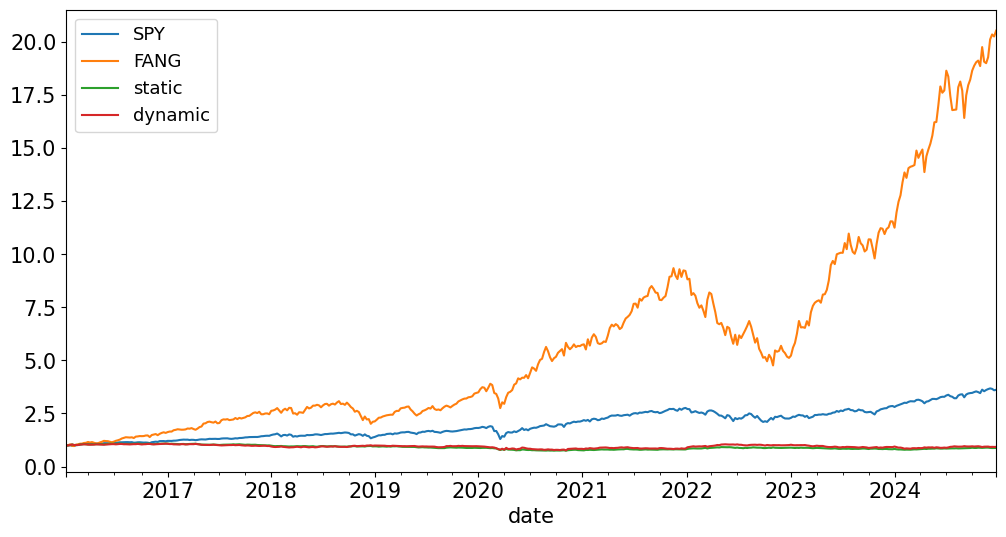

In [15]:
ax = (1+spy).cumprod().plot()
(1+fang).cumprod().plot(ax=ax)
(1+port_rets).cumprod().plot(ax=ax)
display(performanceMetrics(allrets,annualization=FREQ))
display(tailMetrics(port_rets))

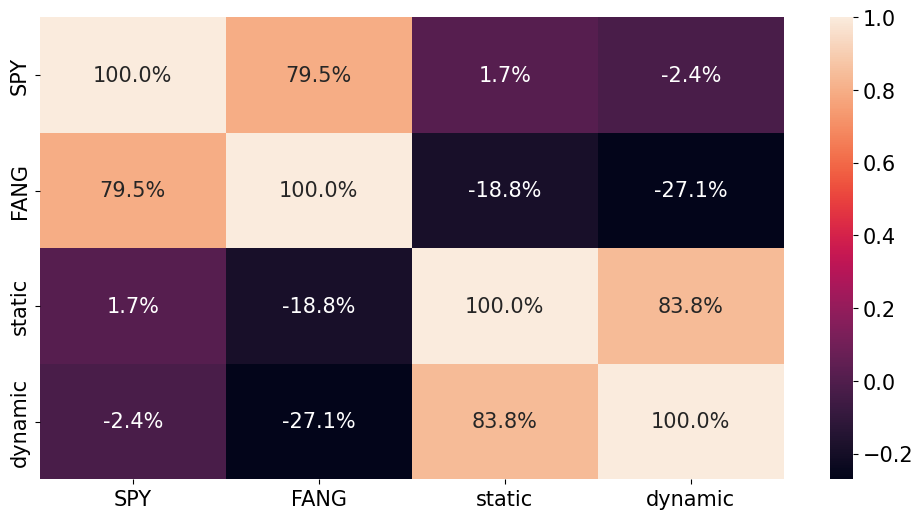

In [19]:
sns.heatmap(allrets.corr(),annot=True,fmt='.1%')
plt.show()

### Linear Factor Decomposition

In [20]:
get_ols_metrics(pd.concat([spy,fang],axis=1),port_rets,annualization=FREQ)

,alpha,SPY,FANG,r-squared,Info Ratio
static,0.0156,0.2075,-0.1606,0.1107,0.2115
dynamic,0.0536,0.3571,-0.3002,0.1728,0.5048
